## SSD default box generator implementation

### motivation
From the paper of SSD, default box generator is subscribed roughly and hard to understand details.  
So I decided to implement the default box generating algorithm for clear understading.  
Hope it'll help others to understand SSD.

### Full Review
I also reviewed the paper in Korea. You can see the review in here. https://yeomko.tistory.com/20

In [149]:
"""
get scale levels for each feature map k.
all values are relative ratio to input image width and height.
"""

S_MIN = 0.2
S_MAX = 0.9
def get_scales(m):
    scales = []    
    for k in range(1, m+1):
        scales.append(round((S_MIN + (S_MAX - S_MIN) / (m - 1) * (k - 1)), 2)) 
    return scales
get_scales(6)

[0.2, 0.34, 0.48, 0.62, 0.76, 0.9]

In [150]:
"""
get default box width and height for feature map k.
all values are relative ratio to input image width and height.
"""
import math


RATIOS = [1, 2, 3, 0.5, 0.33]
def get_width_height(scales):
    width_heights = []
    for k, scale in enumerate(scales):
        print(f'k: {k+1} scale: {scale}')
        width_height_per_scale = []
        for ratio in RATIOS:
            width = min(round((scale *  math.sqrt(ratio)), 2), 1)
            height = min(round((scale /  math.sqrt(ratio)), 2), 1)
            width_height_per_scale.append((width, height))
            print(f'widht: {width} height: {height}')
        if k < len(scales) - 1:
            extra_sacle = round(math.sqrt(scale * scales[k+1]), 2)
            width_height_per_scale.append((extra_sacle, extra_sacle))
            print(f'width: {extra_sacle} height: {extra_sacle}')
        width_heights.append(width_height_per_scale)
        print('')
    return width_heights

scales = get_scales(6)
width_heights = get_width_height(scales)

k: 1 scale: 0.2
widht: 0.2 height: 0.2
widht: 0.28 height: 0.14
widht: 0.35 height: 0.12
widht: 0.14 height: 0.28
widht: 0.11 height: 0.35
width: 0.26 height: 0.26

k: 2 scale: 0.34
widht: 0.34 height: 0.34
widht: 0.48 height: 0.24
widht: 0.59 height: 0.2
widht: 0.24 height: 0.48
widht: 0.2 height: 0.59
width: 0.4 height: 0.4

k: 3 scale: 0.48
widht: 0.48 height: 0.48
widht: 0.68 height: 0.34
widht: 0.83 height: 0.28
widht: 0.34 height: 0.68
widht: 0.28 height: 0.84
width: 0.55 height: 0.55

k: 4 scale: 0.62
widht: 0.62 height: 0.62
widht: 0.88 height: 0.44
widht: 1 height: 0.36
widht: 0.44 height: 0.88
widht: 0.36 height: 1
width: 0.69 height: 0.69

k: 5 scale: 0.76
widht: 0.76 height: 0.76
widht: 1 height: 0.54
widht: 1 height: 0.44
widht: 0.54 height: 1
widht: 0.44 height: 1
width: 0.83 height: 0.83

k: 6 scale: 0.9
widht: 0.9 height: 0.9
widht: 1 height: 0.64
widht: 1 height: 0.52
widht: 0.64 height: 1
widht: 0.52 height: 1



In [101]:
"""
get center indexes for feature map k.
all values are relative ratio to input image width and height.
"""

def get_center(Fk):
    centers = []
    for i in range(Fk):
        for j in range(Fk):
            i_val = round(((i + 0.5)/Fk), 2)
            j_val = round(((j + 0.5)/Fk), 2)
            centers.append((i_val, j_val))
    return centers

25
[(0.1, 0.1), (0.1, 0.3), (0.1, 0.5), (0.1, 0.7), (0.1, 0.9), (0.3, 0.1), (0.3, 0.3), (0.3, 0.5), (0.3, 0.7), (0.3, 0.9), (0.5, 0.1), (0.5, 0.3), (0.5, 0.5), (0.5, 0.7), (0.5, 0.9), (0.7, 0.1), (0.7, 0.3), (0.7, 0.5), (0.7, 0.7), (0.7, 0.9), (0.9, 0.1), (0.9, 0.3), (0.9, 0.5), (0.9, 0.7), (0.9, 0.9)]


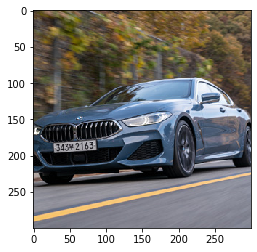

In [146]:
"""
Load image, crop into 300x300 size and plot
"""

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
%matplotlib inline

def center_crop(img, target_h, target_w):
    h, w = img.shape[:2]
    mid_h, mid_w = (h//2, w//2)
    offset_h, offset_w = (target_h//2, target_w//2)
    img = img[mid_h-offset_h:mid_h+offset_h, mid_w-offset_w:mid_w+offset_w]
    return img

def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    plt.close()

img = cv2.imread('car.jpg', cv2.IMREAD_COLOR)
img = center_crop(img, 300, 300)
show_img(img)

(300, 300, 3)


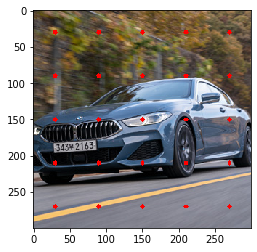

In [147]:
"""
Plot center points, supposing k feature map size is 5
"""
def plot_centers(img, centers):
    print(img.shape)
    w, h = img.shape[:2]
    for center in centers:
        coords = (int(w*center[0]), int(h*center[1]))
        cv2.circle(img, coords, 3, (0, 0,255), -1)

centers = get_center(5)
plot_centers(img, centers)
show_img(img)

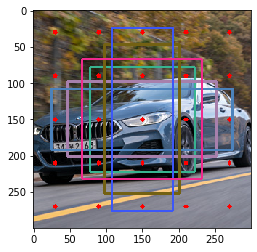

In [148]:
"""
Pick one center and draw default boxes supposing k=3
"""
import random


def plot_default_boxes(img, center, width_height):
    cen_x, cen_y = center
    w, h = img.shape[:2]    
    for w_h in width_height:
        box_w, box_h = w_h
        start = (int(w * (cen_x - (box_w/2))), int(h * (cen_y - box_h/2)))
        end = (int(w * (cen_x + (box_w/2))), int(h * (cen_y + box_h/2)))
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(img, start, end, color, 2)
    


center = centers[12]
width_height = width_heights[2]
plot_default_boxes(img, center, width_height)
show_img(img)